# Summer School - Modeling Water Fluxes In The Soil-Plant System

## Coupling dynamic soil and hydraulic plant architecture models
In this Jupyter Notebook, we combine plant hydraulic architecture models with dynamic soil models. 
In the first part, we couple the plant hydraulic architecture with a dynamic soil grid at the macroscale. 
In the second part, we add individual perirhizal zone models around the single root segments. 


### Coupling plant hydraulic architecture to a macroscopic soil grid
Spatial coupling of the soil and the root hydraulic architecture is done in the *Mapped-Plant class* for general soil grids. *Mapped plant* is a specialisation of the *Plant class*, which keeps track of emerging new nodes and segments and their location inside the numerical soil grid. Therefore, the *MappedPlant class* needs a function that maps each point in space to a linear index (representing a grid cell used by the numeric solver). Temporal coupling is achieved  by solving each of the modules, plant and soil, sequentially, within each time step as described in Giraud et al. (2025).  

The following example simulates root water uptake by a growing root system from a drying soil. 

First, we import all the necessary libraries and set paths to the required directories of CPlantBox and DuMux-Rosi. 


In [ ]:
import timeit
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from richards_flat import RichardsFlatWrapper  # Python part of cylindrical
from rosi_richards_cyl import RichardsCylFoam  # C++ part (Dumux binding), macroscopic soil model

import plantbox as pb
import visualisation.vtk_plot as vp  # for quick visualisations
from functional.PlantHydraulicModel import HydraulicModel_Doussan, HydraulicModel_Meunier
from functional.PlantHydraulicParameters import PlantHydraulicParameters
from richards import RichardsWrapper  # Python part
from rosi_richards import (
    RichardsSP,
    RichardsSPnum,  # C++ part (Dumux binding)
)

sourcedir = "/home/jhack/phd/CPlantBox/"

Next, we set all the necessary parameters for both the soil and the plant models, as well as numerical parameters, and initialise the models. Furthermore, we define points at which the results for the dynamic variables will be stored, in this case the soil cell in which the root collar is located.

In [12]:
def sinusoidal(t: float) -> float: # to plot daily variation in transpiration
    """ 
    Sinusoidal function (used for transpiration) (integral over one day is 1).
    
    Args:
        t (float): Time [days].
    
    Returns:
        float: Sinusoidal value at time t.
    """
    return np.sin(2. * np.pi * np.array(t) - 0.5 * np.pi) + 1.

def soil_picker(x: float, y: float, z: float, soil_model) -> int:
    """
    Maps a 3D coordinate (x, y, z) to the corresponding soil grid cell index.

    This function wraps the Richards solver's `pick()` method, which returns
    the index of the grid cell containing the given coordinates. It is used
    to couple plant root segments to the soil model in CPlantBox simulations.

    Args:
        x (float): X-coordinate [cm].
        y (float): Y-coordinate [cm].
        z (float): Z-coordinate [cm].
        soil_model: The soil model object (e.g. a RichardsWrapper instance).

    Returns:
        int: The index of the soil grid cell containing the point (x, y, z).
    """
    return soil_model.pick([x, y, z])

older = True # True for older parameters (more transpiration, drier soil), False for newer ones (less transpiration, wetter soil)

""" Parameters """
if older:
    min_b = [-4., -4., -100.] # soil domain boundaries [cm]
    max_b = [4., 4., 0.]
    cell_number = [4 , 4, 50]  # [16, 16, 30]  # [32, 32, 60]
else: 
    min_b = [-4., -4., -25.]
    max_b = [4., 4., 0.]
    cell_number = [8, 8, 25] 
periodic = False

path = sourcedir+"modelparameter/structural/rootsystem/"
name = "Zeamays_synMRI_modified" 
loam = [0.08, 0.43, 0.04, 1.6, 50] # VG parameters for loam [theta_r, theta_s, alpha, n, Ks]

if older:
    initial = -12000 # cm, drier initial condition
else:
    initial = -659.8 + 12.5

if older:
    trans = 12.8  # cm3 /day (sinusoidal) potential transpiration
else:
    trans = 6.4
    
wilting_point = -15000  # cm
sim_time = 2.5  # [day] 

if older:
    rs_age = 55  # root system initial age
else:
    rs_age = 10.
    
age_dependent = False  # conductivities
dt = 360. / (24 * 3600)  # [days] Time step must be very small


""" Initialize macroscopic soil model """
s = RichardsWrapper(RichardsSP()) # defines Richards soil physics solver; Python Wrapper for C++ part
s.initialize()
s.createGrid(min_b, max_b, cell_number, periodic)  # [cm]; sets computational grid
s.setHomogeneousIC(initial, True)  # cm uniform pressure head, equilibrium
s.setTopBC("noFlux") # no Flux --> isolated system
s.setBotBC("noFlux")
s.setVGParameters([loam]) # apply soil hydraulic parameters
s.setParameter("Soil.SourceSlope", "1000") # numerical parameter for root-soil coupling stability
s.initializeProblem()
s.setCriticalPressure(wilting_point) # sets wilting point threshold

""" Initialize xylem model """
plant = pb.MappedPlant(1)
plant.enableExtraNode() # dummy node for atmosphere connection/ transpiration
plant.readParameters(path + name + ".xml")
if not periodic:
    sdf = pb.SDF_PlantBox(0.95 * (max_b[0] - min_b[0]), 0.95 * (max_b[1] - min_b[1]), # smaller than full soil domain (95%) to avoid boundary effects
                          0.95 * (max_b[2] - min_b[2]))
else:
    sdf = pb.SDF_PlantBox(np.Inf, np.Inf, max_b[2] - min_b[2]) # infinite lateral size for periodic
plant.setGeometry(sdf)

""" root hydraulic properties """
params = PlantHydraulicParameters()  
params.read_parameters(sourcedir+"/modelparameter/functional/plant_hydraulics/couvreur2012")
hm = HydraulicModel_Doussan(plant, params) # steady state xylem flow
# hm = HydraulicModel_Meunier(plant, params)
hm.wilting_point = wilting_point

""" Coupling (map indices) """
picker = partial(soil_picker, soil_model=s)  # function to map coordinates to soil grid indices
plant.setSoilGrid(picker)  # maps segments
plant.initialize(True)
plant.simulate(rs_age, True)
hm.test()  # sanity checks

Computed bounding box tree with 1599 nodes for 800 grid entities in 0.0004986 seconds.
Computed bounding box tree with 1599 nodes for 800 grid entities in 0.0002037 seconds.
MappedPlant::initializeLB 
Seed::initialize: RootSystem 
Seed::initialize: Shoot borne definition is DEPRICATED, shoot borne roots will be handeled like basal roots 
Organism::simulate: from 0 to 55 days
nodes moved 0
new nodes added 46802
segments added 46802
Number of segments 46803, including 46802 new 
PlantHydraulicModel.test():
46804 nodes:
Node 0 [ 0.1  0.  -3. ]
Node 1 [ 0.  0. -3.]
Node 2 [ 3.90677854e-04 -4.04361472e-04 -3.49999968e+00]
Node 3 [ 0.04357861 -0.00965854 -3.99804503]
Node 4 [ 0.06790249 -0.01641161 -4.3738381 ]
46803 segments:
Segment 0 [0 1] subType 0
Segment 1 [1 2] subType 1
Segment 2 [2 3] subType 1
Segment 3 [3 4] subType 1
Segment 4 [4 5] subType 2
Collar segment index 0
Collar segment [0 1]
0 segments with length < 1.e-5 cm
6 different root types from 0 to 5
ages from 0 to 55
segments

In the main simulation loop, we sequentially perform (a) plant growth, (b) compute xylem pressure potential and (c) calculate the fluxes from soil grid cells into the plant roots as well as the soil matric potentials. The resulting actual transpiration at each time step is stored. Two figurs are produced, one that shows the soil matric potentials in the 3D soil domain as well as the root architecture and xylem pressure potentials, and a 2D plot that shows the actual, potential and cumulative transpiration with respect to time.  

In [13]:
""" Numerical solution """
start_time = timeit.default_timer() # Start timer for performance measurement
x_, y_ = [], [] # time, root collar flux/ transpiration
N = round(sim_time / dt) # number of time steps
t = 0. # initial time

for i in range(0,N):

    plant.simulate(dt)
    hs = s.getSolutionHead() # soil water potentials at all grid cells at t
    hx = hm.solve(rs_age+t, -trans*sinusoidal(t), hs, cells=True) # xylem water potentials at all segments at t; transpiration demand; soil potentials; mapping
    
    water = s.getWaterVolume()
    fluxes = hm.soil_fluxes(rs_age+t,hx,hs) # compute soil fluxes = root water uptake per soil cell
    s.setSource(fluxes)
    s.solve(dt) # advance soil solution by dt
    soil_water = (s.getWaterVolume() - water) / dt # net change in soil water volume per time step (cm3/day)
    
    x_.append(t)
    y_.append(float(hm.get_transpiration(rs_age + t, hx, hs, cells=True)))  # exact root collar flux/ total transpiration
    
    if i % 2 == 0:
        n = round(i / N * 100)
        bar = "*" * n + " " * (100 - n)
        print(
            f"[{bar}]  "
            f"Soil head: [{np.min(hs):.2f}, {np.max(hs):.2f}] cm | "
            f"Root head: [{np.min(hx):.2f}, {np.max(hx):.2f}] cm | "
            f"Time: {s.simTime:.2f} days | "
            f"Root collar: {hx[0]:.2f} cm"
        )
 
    t += dt

print (f"Coupled problem solved in {timeit.default_timer() - start_time:.2f} s")

[                                                                                                    ]  Soil head: [-12049.00, -11951.00] cm | Root head: [-18491.22, -11976.86] cm | Time: 0.00 days | Root collar: -12083.13 cm
[                                                                                                    ]  Soil head: [-12140.37, -11951.00] cm | Root head: [-18516.70, -11980.67] cm | Time: 0.01 days | Root collar: -12105.54 cm
[*                                                                                                   ]  Soil head: [-12192.98, -11951.00] cm | Root head: [-18537.39, -11984.79] cm | Time: 0.02 days | Root collar: -12124.84 cm
[*                                                                                                   ]  Soil head: [-12226.94, -11951.00] cm | Root head: [-18556.96, -11989.26] cm | Time: 0.03 days | Root collar: -12143.76 cm
[*                                                                                              

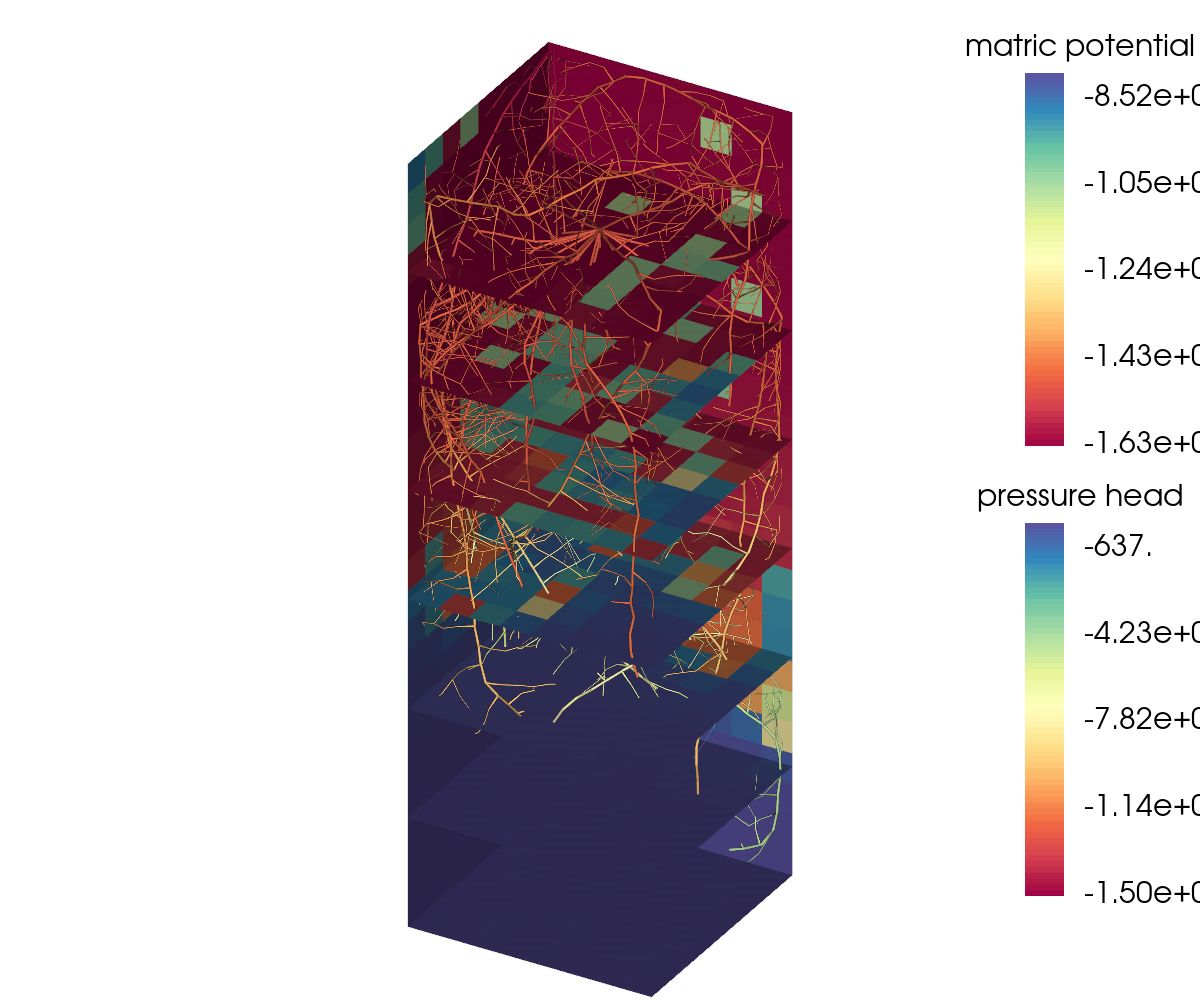

2025-10-13 10:26:12.879 (4647.514s) [    71527B285080]       vtkXMLWriter.cxx:633    ERR| vtkXMLPolyDataWriter (0x297c1d50): Error opening output file "results/Zeamays_synMRI_modified.vtp"
2025-10-13 10:26:12.880 (4647.514s) [    71527B285080]       vtkXMLWriter.cxx:635    ERR| vtkXMLPolyDataWriter (0x297c1d50): Error code "No such file or directory"
2025-10-13 10:26:12.880 (4647.514s) [    71527B285080]       vtkExecutive.cxx:729    ERR| vtkCompositeDataPipeline (0x2bb214b0): Algorithm vtkXMLPolyDataWriter (0x297c1d50) returned failure for request: vtkInformation (0x263fc210)
  Debug: Off
  Modified Time: 134152
  Reference Count: 1
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: -1
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0


2025-10-13 10:26:12.891 (4647.525s) [    71527B285080]       vtkXMLWriter.cxx:633    ERR| vtkXMLImageDataWriter (0x2b7ca960): Error opening output file "results/Zeamays_synMRI_modified.vtu"
2025-10-13 10:26:12.891 (4647.525s) [  

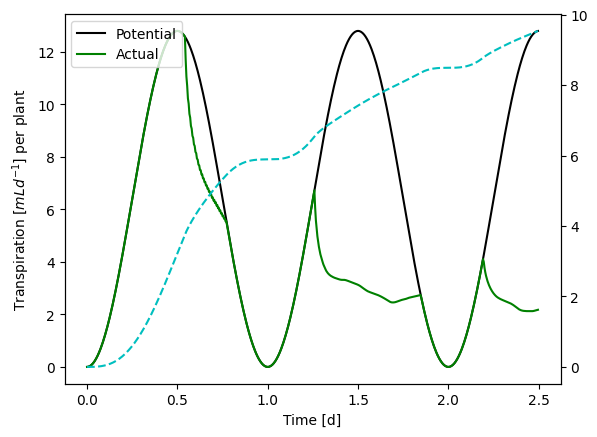

In [ ]:
""" VTK visualisation """
vp.plot_roots_and_soil(hm.ms.mappedSegments(), # hydraulic model.mapped root segments.returns list of segments: coordinates, root order, mapped soil index, hydraulic properties
                       "matric potential", # variable to color visualization by
                       hx, # array of xylem pressure heads; cells=True earlier --> one value per segment; variable for coloring
                       s, # RichardsWrapper soil model instance: provides soil pressure heads and grid
                       True, # include soil domain in visualization
                       np.array(min_b), # bounding box of soil
                       np.array(max_b), # bounding box of soil
                       cell_number, # number of soil cells in each direction
                       name, # filename of root system
                       interactiveImage = False) # set to True for interactive window, False for static image

""" transpiration over time """
fig, ax1 = plt.subplots()
ax1.plot(x_, trans * sinusoidal(x_), 'k')  # potential transpiration; k --> black
ax1.plot(x_, -np.array(y_), 'g')  # actual transpiration (neumann); g --> green
ax2 = ax1.twinx()
ax2.plot(x_, np.cumsum(-np.array(y_) * dt), 'c--')  # cumulative transpiration (neumann); c --> cyan
ax1.set_xlabel("Time [d]")
ax1.set_ylabel("Transpiration $[mL d^{-1}]$ per plant")
ax1.legend(['Potential', 'Actual', 'Cumulative'], loc = 'upper left')
np.savetxt(name, np.vstack((x_, -np.array(y_))), delimiter = ';') # save time and actual transpiration to CSV-like file
plt.show()

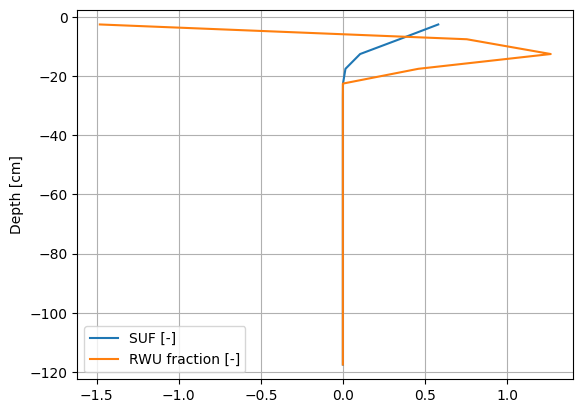

In [ ]:
def get_1d_from_3d_suf(hm: HydraulicModel_Meunier | HydraulicModel_Doussan, suf: np.ndarray, name: str, z_min: int) -> tuple[np.ndarray, np.ndarray]:
    """Convert 3D SUF (Standard Uptake Fraction) data to 1D depth profile for given hydraulic model and SUF values at each segment.
    
    Args:
        hm: Hydraulic model instance (either Meunier or Doussan); contains the mapped segments.
        suf: Array of SUF values at each segment in the 3D root structure.

    Returns:
        suf_array: 1D array of SUF values averaged over horizontal layers.
        depth_array: Corresponding depth midpoints for the SUF values [cm].
        name: Name identifier for the data (used in SegmentAnalyser).
        z_min: Minimum depth to consider for binning [cm].

    Notes:
        The function bins the root system along the z-axis (soil depth) with 5 cm layers (bin size hardcoded in function) 
        and computes the total SUF in each layer.
    """
    ana = pb.SegmentAnalyser(hm.ms)
    ana.addData(name, suf)  # suf at each segment in the 3d space; adds a field (name) containing per segment values
    
    bin_size = 5  # soil layer thickness is defined, for plotting purposes
    z_max = 0
    n_bins = int((z_max - z_min) / bin_size)
    suf_dist = ana.distribution(name, z_max, z_min, n_bins, True) # total suf per depth layer; args: data field, bounds, layers, normalize per layer
    
    depths = np.linspace(z_max - bin_size / 2, z_min + bin_size / 2, n_bins) # depth midpoints of layers
    suf_array = np.array(suf_dist) # array of suf values
    depth_array = np.array(depths) # array of depths
    return suf_array, depth_array
    
suf_array, depth_array = get_1d_from_3d_suf(hm, hm.get_suf(rs_age+t), "SUF", -120.) # water uptake potential distributed through depth layers
hx = hm.solve(rs_age, -trans*sinusoidal(0.5), hs, cells=True) # solve for water potential 
radial_fluxes = hm.radial_fluxes( rs_age+t, hx, hs, cells = True) # compute actual water flux across root membrane
rwu_array, depth_array = get_1d_from_3d_suf(hm, radial_fluxes, "RWU", -120.) # convert to 1D
rwu_array /= sum(rwu_array) # normalize to sum to 1 --> distribution of actual water uptake through depth layers

plt.plot(suf_array, depth_array, label = "SUF [-]")
plt.plot(rwu_array, depth_array, label = "RWU fraction [-]") # RWU = Root Water Uptake
plt.ylabel("Depth [cm]")
plt.grid(True)
plt.ylim(depth_array.min() - 5, depth_array.max() + 5)  # optional padding
plt.legend()
plt.show()  